In [1]:
pacman::p_load(tidyverse, sigfit, readxl, vcfR, VariantAnnotation, rtracklayer, Biostring, Rsamtools, patchwork)

Installing package into ‘/n/data1/bch/genetics/lee/eam63/tools/R-4.2.1/library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘sigfit’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message in p_install(package, character.only = TRUE, ...):
“”
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘sigfit’”
Installing package into ‘/n/data1/bch/genetics/lee/eam63/tools/R-4.2.1/library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘Biostring’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message in p_install(package, character.only = TRUE, ...):

Rows: 3383 Columns: 28
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (11): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (15): POS, VAF[alleles, BSMN], BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCN...
num  (2): FORMAT/AD, FORMAT/PL

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 6426 Columns: 137
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (47): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (85): POS, AF, BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCNVcount, GWASpval...
lgl  (5): targetscan_Reg

ID,Dx,mean_cov
<chr>,<chr>,<dbl>
MSSM_027_NeuN_pl,SCZ,256.1440
MSSM_055_NeuN_pl,SCZ,287.7580
MSSM_056_NeuN_pl,SCZ,123.4260
MSSM_069_NeuN_pl,SCZ,59.6804
MSSM_097_NeuN_pl,SCZ,444.0040
MSSM_099_NeuN_pl,SCZ,309.5520


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


Dx,avg_cov,max_cov,min_cov,median_cov
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Control,245.3304,503.417,59.6804,244.489
SCZ,224.4498,532.064,52.2932,232.637


[1] 238.6865



	Wilcoxon rank sum test with continuity correction

data:  data %>% distinct(`Individual ID`, .keep_all = TRUE) %>% filter(Dx != "SCZ") %>% pull(mean_cov) and data %>% distinct(`Individual ID`, .keep_all = TRUE) %>% filter(Dx == "SCZ") %>% pull(mean_cov)
W = 855, p-value = 0.3816
alternative hypothesis: true location shift is not equal to 0


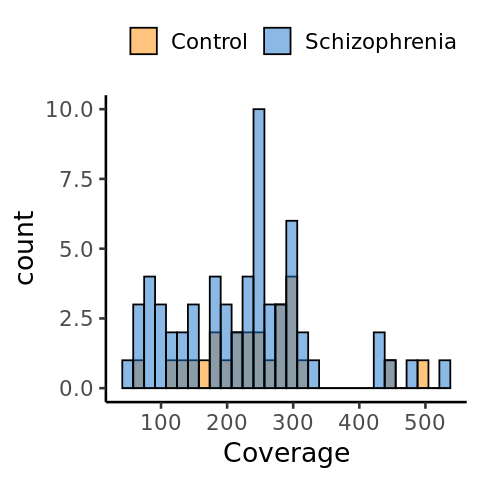

In [2]:
## Coverage comparison between SCZ and controls

library(tidyverse)
data_vaf = read_csv("../../data/annotated-calls_vaf.csv") %>% 
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data = read_csv("../../data/annotated-calls.csv") %>%
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data$AF = data_vaf$`VAF[reads, BSMN]`[match(data$var_id, data_vaf$var_id)]
data = data %>% filter(AF < 0.40, Dx != "ASD")

## Get hte coverage information
cov_info = read_tsv("../../data/BSM_MSSM_SCZ_coverage.txt", col_names = c("ID","Dx","mean_cov"))
head(cov_info)

data = data %>% mutate(subjectID = str_split(`Individual ID`,"_",n=2,simplify=TRUE)[,2]) 
cov_info$subjectID = unlist(lapply(strsplit(cov_info$ID,"_"), function(x) {paste(x[1:2],collapse="_")}))

data$mean_cov = cov_info$mean_cov[match(data$subjectID,cov_info$subjectID)]

## Check coverage in cases vs control
options(repr.plot.width = 4, repr.plot.height = 4)
data = data %>% filter(Dataset == "Chess")

p1 = data %>% distinct(`Individual ID`,`.keep_all` = TRUE) %>% ggplot(aes(x=mean_cov)) +
    geom_histogram(position="identity",aes(fill=Dx),color="black", alpha=0.5) + 
    theme_classic(base_size=16) +
    scale_fill_manual(values = c("darkorange","dodgerblue3"), labels=c("Control","Schizophrenia")) + 
    labs(x = "Coverage", fill="") +
    theme(legend.position = "top")
p1

data %>% distinct(`Individual ID`,`.keep_all` = TRUE) %>% group_by(Dx) %>% 
    summarise(avg_cov = mean(mean_cov), max_cov = max(mean_cov), min_cov = min(mean_cov), median_cov = median(mean_cov))
print(median(cov_info$mean_cov))


wilcox.test(y=data %>% distinct(`Individual ID`,`.keep_all` = TRUE) %>% filter(Dx=="SCZ") %>%pull(mean_cov),
        x= data %>% distinct(`Individual ID`,`.keep_all` = TRUE) %>%filter(Dx!="SCZ") %>% pull(mean_cov))

# ggsave(p1,filename = "../figures/coverage_histogram.pdf",device="pdf",width=4,height=4)

In [3]:
## Call-set
data_vaf = read_csv("../../data/annotated-calls_vaf.csv") %>% 
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data = read_csv("../../data/annotated-calls.csv") %>%
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data$AF = data_vaf$`VAF[reads, BSMN]`[match(data$var_id, data_vaf$var_id)]
data$nREF = data_vaf$REFD[match(data$var_id,data_vaf$var_id)]
data$nALT = data_vaf$ALTD[match(data$var_id,data_vaf$var_id)]
data = data %>% filter(AF < 0.40, Dx != "ASD")


data %>% dplyr::select(c(`Individual ID`, CHROM, POS, REF, ALT, AF, nREF,nALT)) %>%
    mutate(DP = nREF + nALT, AF = round(AF,2)) %>%
    dplyr::rename(`position (hg19)` = POS, `reference allele` = REF, `alternate allele` = ALT, 
                 VAF = AF, `number reference alleles` = nREF, `number alternate alleles` = nALT,
                 `coverage at site` = DP, chromosome=CHROM) %>% write_csv(file = "../../data/TableS3.csv")



Rows: 3383 Columns: 28
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (11): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (15): POS, VAF[alleles, BSMN], BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCN...
num  (2): FORMAT/AD, FORMAT/PL

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 6426 Columns: 137
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (47): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (85): POS, AF, BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCNVcount, GWASpval...
lgl  (5): targetscan_Reg

Rows: 3383 Columns: 28
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (11): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (15): POS, VAF[alleles, BSMN], BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCN...
num  (2): FORMAT/AD, FORMAT/PL

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 6426 Columns: 137
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (47): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (85): POS, AF, BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCNVcount, GWASpval...
lgl  (5): targetscan_Reg

[1] 0.009174312 0.397196262

Rows: 36 Columns: 10
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): REF, ALT, Individual ID
dbl (7): CHROM, POS, AF, nREF_val, nALT_val, frac_val, attempted

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 0.8670051

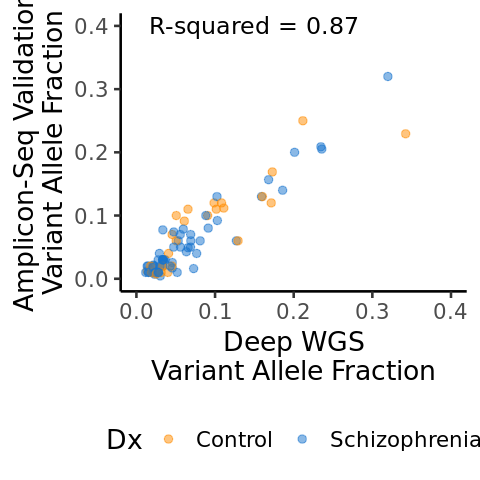

In [4]:
## Amplicon-seq validation plot

data_vaf = read_csv("../../data/annotated-calls_vaf.csv") %>% 
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data = read_csv("../../data/annotated-calls.csv") %>%
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data$AF = data_vaf$`VAF[reads, BSMN]`[match(data$var_id, data_vaf$var_id)]
data = data %>% filter(AF < 0.40, Dx != "ASD")
range(data$AF)
data = data %>% mutate(id = paste(`Individual ID`, CHROM, POS, REF,ALT,sep = ";"))
val_vars = read_csv("../../resources/variants_to_validate.csv") %>% 
    mutate(id = paste(`Individual ID`, CHROM, POS, REF,ALT,sep = ";")) %>% mutate(val_AF = nALT_val/(nREF_val+nALT_val)) %>%
    mutate(validated =ifelse(frac_val >= 0.01,1,0)) %>%
    dplyr::select(c(id, val_AF, attempted, validated))


val_frac = readxl::read_xlsx("../../data/SCZvalidation_062722_YC_eam.xlsx",sheet=2) 
val_frac2 = val_frac %>% mutate(id = paste(`Individual ID`, CHROM, POS, REF, ALT,sep=";"), 
                                 attempted = ifelse(comments !="low_coverage",1,0), val_AF = nVAF) %>%
    dplyr::select(c(id, val_AF, attempted,validated))

val_frac2 = rbind(val_vars,val_frac2) %>% distinct(id,.keep_all = TRUE)

# data$val_frac = val_vars$frac_val[match(data$id, val_vars$id)]

data$val_AF = val_frac2$val_AF[match(data$id, val_frac2$id)]
data$attempted = val_frac2$attempted[match(data$id, val_frac2$id)]

data$validated = val_frac2$validated[match(data$id, val_frac2$id)]

options(repr.plot.width = 4, repr.plot.height = 4)


summary(lm(AF ~ val_AF, data=data %>% filter(attempted==1, validated==1)))$r.squared

p1= data %>% filter(attempted == 1, validated==1) %>% ggplot(aes(x=AF, y=val_AF)) + 
    geom_point(size=2, aes(color=Dx),alpha=0.5) + theme_classic(16) +
    ylim(c(0,0.4)) + xlim(c(0,0.4)) + #geom_smooth(method="lm") + 
    scale_color_manual(values = c("darkorange","dodgerblue3"), labels=c("Control","Schizophrenia")) + 
    labs(x = "Deep WGS\nVariant Allele Fraction",y="Amplicon-Seq Validation\nVariant Allele Fraction") +
    annotate(geom="text",label= paste("R-squared =",
                                     round(summary(lm(AF ~ val_AF, data=data %>% filter(attempted==1)))$r.squared,2)),
            x=0.15,y=0.4, size=5) +
    theme(legend.position = "bottom")

p1

ggsave(p1, filename = "../../figures/validation_figure_no_outlier.pdf",device="pdf",height=4, width=4)

Rows: 3383 Columns: 28
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (11): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (15): POS, VAF[alleles, BSMN], BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCN...
num  (2): FORMAT/AD, FORMAT/PL

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 6426 Columns: 137
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (47): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (85): POS, AF, BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCNVcount, GWASpval...
lgl  (5): targetscan_Reg

Dx,Individual ID,n
<chr>,<chr>,<int>
SCZ,CMC_MSSM_224,188


`summarise()` has grouped output by 'Individual ID', 'Dx', 'ageOfDeath'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Individual ID'. You can override using the `.groups` argument.


Dx,mean_muts,median_muts
<chr>,<dbl>,<dbl>
Control,34.48000,28
SCZ,37.26667,36


Dx,n
<chr>,<int>
Control,862
SCZ,2236


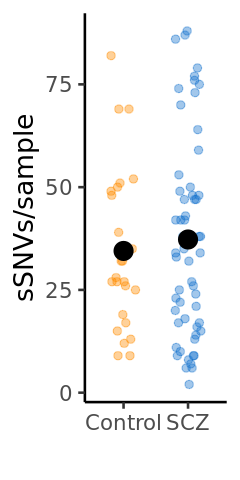

In [5]:
## Analysis to compare genome-wide rates in SCZ compared to controls per sample

data_vaf = read_csv("../../data/annotated-calls_vaf.csv") %>% 
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data = read_csv("../../data/annotated-calls.csv") %>%
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data$AF = data_vaf$`VAF[reads, BSMN]`[match(data$var_id, data_vaf$var_id)]
data = data %>% filter(AF < 0.40, Dx != "ASD")
cov_info = read_tsv("../../data/BSM_MSSM_SCZ_coverage.txt", col_names = c("ID","Dx","mean_cov"))
data = data %>% mutate(subjectID = str_split(`Individual ID`,"_",n=2,simplify=TRUE)[,2]) 
cov_info$subjectID = unlist(lapply(strsplit(cov_info$ID,"_"), function(x) {paste(x[1:2],collapse="_")}))

data$mean_cov = cov_info$mean_cov[match(data$subjectID,cov_info$subjectID)]
data = data %>% filter(Dataset == "Chess")

data %>% dplyr::count(Dx, `Individual ID`) %>% filter(`Individual ID` == "CMC_MSSM_224")

## filter outlier
data = data %>% filter(`Individual ID` != "CMC_MSSM_224") 

overall_rate_0 = data %>%
    group_by(`Individual ID`, Dx, ageOfDeath,`PMI (in hours)`) %>% 
    dplyr::summarize(muts = n(), avg_DP = median(mean_cov)) %>% ungroup()

data %>% group_by(`Individual ID`,Dx) %>% dplyr::summarize(muts = n()) %>% ungroup() %>%
    group_by(Dx) %>% dplyr::summarize(mean_muts = mean(muts), median_muts = median(muts))

data %>% dplyr::count(Dx)

options(repr.plot.width = 2, repr.plot.height = 4)
p1 = overall_rate_0 %>% ggplot(aes(x=Dx, y=muts)) + 
#     geom_violin(aes(fill = Dx), alpha=0.2, show.legend=FALSE) +
    geom_jitter(aes(color = Dx), width=0.2, height=0,size=2, alpha=0.4,show.legend = FALSE) +
    stat_summary(color="black", fun = "mean", geom = "point", size=5, show.legend = FALSE) +
    scale_color_manual(values = c("darkorange","dodgerblue3"), breaks = c("Control","SCZ")) +
    scale_fill_manual(values = c("darkorange","dodgerblue3"), breaks = c("Control","SCZ")) +
    theme_classic(base_size = 16) + labs(y="sSNVs/sample",x="") 

p1
# ggsave(p1,filename = "../figures/snv_burden_no_outlier.pdf",device="pdf", height=4, width=2)

Rows: 64 Columns: 27
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (15): ID, newHaplotype_1, newHaplotype_2, newHaplogroup_1, newHaplogroup...
dbl (12): SCZ.3_PRS, age, PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 86 Columns: 24
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): Individual ID, Institution, Reported Gender, Ethnicity, Dx, Sequen...
dbl (18): ageOfDeath, Brain Weight (in grams), PMI (in hours), Year of Autop...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Call:
glm(formula = muts ~ scale(avg_DP), family = "poisson", data = c4_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.9465  -2.1272  -0.2382   1.2817   6.1871  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    3.47134    0.02503  138.71   <2e-16 ***
scale(avg_DP)  0.47261    0.02154   21.94   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 787.02  on 53  degrees of freedom
Residual deviance: 323.79  on 52  degrees of freedom
  (10 observations deleted due to missingness)
AIC: 607.13

Number of Fisher Scoring iterations: 4



Call:
glm(formula = muts ~ scale(PMI), family = "poisson", data = c4_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.4157  -3.4397  -0.0753   1.9898   7.4705  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.570401   0.020971  170.26   <2e-16 ***
scale(PMI)  -0.004859   0.021172   -0.23    0.818    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 849.51  on 63  degrees of freedom
Residual deviance: 849.45  on 62  degrees of freedom
AIC: 1185

Number of Fisher Scoring iterations: 5



Call:
glm(formula = muts ~ Sequencing, family = "poisson", data = c4_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.9300  -2.6690  -0.2251   1.6927   6.6497  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      3.67387    0.02324 158.105   <2e-16 ***
Sequencingother -0.46208    0.05394  -8.566   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 849.51  on 63  degrees of freedom
Residual deviance: 768.96  on 62  degrees of freedom
AIC: 1104.5

Number of Fisher Scoring iterations: 5



Call:
glm(formula = muts ~ YoA, family = "poisson", data = c4_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.9728  -3.4320  -0.1059   2.2561   7.0066  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) 26.710412   6.526234   4.093 4.26e-05 ***
YoA         -0.011560   0.003261  -3.545 0.000392 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 849.51  on 63  degrees of freedom
Residual deviance: 837.01  on 62  degrees of freedom
AIC: 1172.5

Number of Fisher Scoring iterations: 5



Call:
glm(formula = muts ~ scale(ageOfDeath), family = "poisson", data = c4_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.2507  -3.3900  -0.3273   1.9690   7.5157  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)        3.56962    0.02099 170.089   <2e-16 ***
scale(ageOfDeath) -0.03996    0.02105  -1.899   0.0576 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 849.51  on 63  degrees of freedom
Residual deviance: 845.91  on 62  degrees of freedom
AIC: 1181.4

Number of Fisher Scoring iterations: 5



Call:
glm(formula = muts ~ causeOfDeath, family = "poisson", data = c4_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.4525  -3.4518  -0.0881   1.9985   7.3961  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   3.571227   0.033147 107.739   <2e-16 ***
causeOfDeath -0.001016   0.013531  -0.075     0.94    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 849.34  on 62  degrees of freedom
Residual deviance: 849.33  on 61  degrees of freedom
  (1 observation deleted due to missingness)
AIC: 1179.4

Number of Fisher Scoring iterations: 5



Call:
glm(formula = muts ~ Institution, family = "poisson", data = c4_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.5339  -3.4018   0.1744   2.0543   7.2679  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      3.58824    0.02425 147.947   <2e-16 ***
InstitutionPitt -0.06882    0.04827  -1.426    0.154    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 849.51  on 63  degrees of freedom
Residual deviance: 847.45  on 62  degrees of freedom
AIC: 1183

Number of Fisher Scoring iterations: 5


Warning message:
“Removed 10 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 10 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


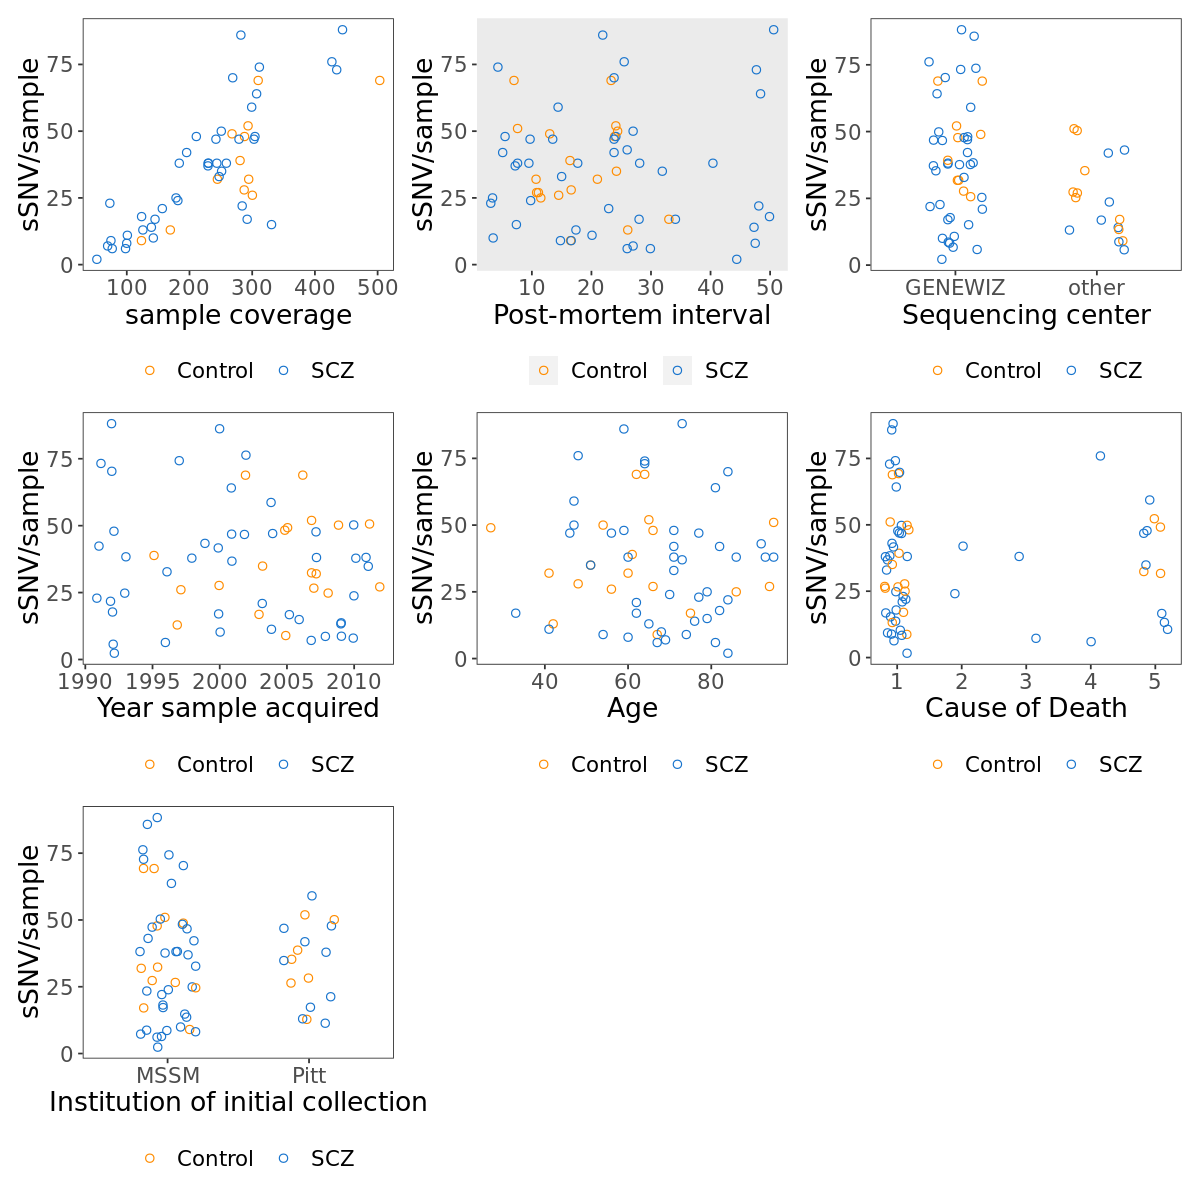

In [6]:
c4_data = read_tsv("../../data/C4_results_covars.tsv")

c4_data = c4_data %>% mutate(id = str_replace(ID,"_NeuN_pl","")) %>%
mutate(id = str_c("CMC_",id))

mutation_burden = data %>% dplyr::count(`Individual ID`)


c4_data$Dx = data$Dx[match(c4_data$id,data$`Individual ID`)]
c4_data$muts = mutation_burden$n[match(c4_data$id, mutation_burden$`Individual ID`)]

c4_data$avg_DP = cov_info$mean_cov[match(c4_data$ID,cov_info$ID)]
c4_data$PMI = data$`PMI (in hours)`[match(c4_data$id,data$`Individual ID`)]

c4_data$PRS = c4_data$SCZ.3_PRS

site_data <- read_csv("../../data/subjects-sequencing-ancestry-attila.csv")

c4_data$Sequencing = site_data$Sequencing[match(c4_data$id,site_data$`Individual ID`)]
c4_data$YoA = site_data$`Year of Autopsy`[match(c4_data$id,site_data$`Individual ID`)]
c4_data$causeOfDeath = site_data$causeOfDeath[match(c4_data$id,site_data$`Individual ID`)]
c4_data$ageOfDeath = site_data$ageOfDeath[match(c4_data$id,site_data$`Individual ID`)]
c4_data$Institution = site_data$Institution[match(c4_data$id, site_data$`Individual ID`)]

c4_data %>% 
    dplyr::select(c(ID,avg_DP,PMI,sex,PC1, PC2, PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Dx,Sequencing, YoA,ageOfDeath, causeOfDeath, Institution)) %>%
    write_csv("../../data/regression_table.csv")

## plotting relationship of covars with sSNV

p1 = c4_data %>% ggplot(aes(x=avg_DP, y=muts)) +
    geom_point(aes(color=Dx),shape=1,size=2) + theme_bw() +
    theme(text = element_text(size=16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_blank(),
    legend.position = "bottom") +
    labs(color="", x="sample coverage",y= "sSNV/sample") +
    scale_color_manual(values=c("darkorange","dodgerblue3"))

summary(glm(muts ~ scale(avg_DP) , data=c4_data, family="poisson"))

p2 = c4_data %>% ggplot(aes(x=PMI, y=muts)) +
    geom_point(aes(color=Dx),shape=1,size=2) + theme_set(theme_bw()) +
    theme(text = element_text(size=16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_blank(),
    legend.position = "bottom") +
    labs(color="", x="Post-mortem interval", y = "sSNV/sample") +
    scale_color_manual(values=c("darkorange","dodgerblue3"))

summary(glm(muts ~ scale(PMI) , data=c4_data, family="poisson"))

p3 = c4_data %>% ggplot(aes(x=Sequencing, y=muts)) +
    geom_jitter(aes(color=Dx),shape=1,size=2,width=0.2) + theme_set(theme_bw()) +
    theme(text = element_text(size=16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_blank(),
    legend.position = "bottom") +
    labs(color="", x="Sequencing center", y = "sSNV/sample") +
    scale_color_manual(values=c("darkorange","dodgerblue3"))

summary(glm(muts ~ Sequencing , data=c4_data, family="poisson"))

p4 = c4_data %>% ggplot(aes(x=YoA, y=muts)) +
    geom_jitter(aes(color=Dx),shape=1,size=2,width=0.2) + theme_set(theme_bw()) +
    theme(text = element_text(size=16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_blank(),
    legend.position = "bottom") +
    labs(color="", x="Year sample acquired", y = "sSNV/sample") +
    scale_color_manual(values=c("darkorange","dodgerblue3"))
summary(glm(muts ~ YoA , data=c4_data, family="poisson"))

p5 = c4_data %>% ggplot(aes(x=ageOfDeath, y=muts)) +
    geom_point(aes(color=Dx),shape=1,size=2) + theme_set(theme_bw()) +
    theme(text = element_text(size=16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_blank(),
    legend.position = "bottom") +
    labs(color="", x="Age", y = "sSNV/sample") +
    scale_color_manual(values=c("darkorange","dodgerblue3"))
summary(glm(muts ~ scale(ageOfDeath) , data=c4_data, family="poisson"))

p6 = c4_data %>% ggplot(aes(x=causeOfDeath, y=muts)) +
    geom_jitter(aes(color=Dx),shape=1,size=2,width=0.2) + theme_set(theme_bw()) +
    theme(text = element_text(size=16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_blank(),
    legend.position = "bottom") +
    labs(color="", x="Cause of Death", y = "sSNV/sample") +
    scale_color_manual(values=c("darkorange","dodgerblue3"))
summary(glm(muts ~ causeOfDeath , data=c4_data, family="poisson"))

p7 = c4_data %>% ggplot(aes(x=Institution, y=muts)) +
    geom_jitter(aes(color=Dx),shape=1,size=2,width=0.2) + theme_set(theme_bw()) +
    theme(text = element_text(size=16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_blank(),
    legend.position = "bottom") +
    labs(color="", x="Institution of initial collection", y = "sSNV/sample") +
    scale_color_manual(values=c("darkorange","dodgerblue3"))
summary(glm(muts ~ Institution , data=c4_data, family="poisson"))

library(patchwork)

options(repr.plot.width=10, repr.plot.height=10)
final_plot = wrap_plots(p1,p2,p3,p4,p5,p6,p7)
final_plot

ggsave(filename="../../figures/covars_muts_plot.pdf",device="pdf",height=10,width=10)

Warning message in add1.glm(fit, scope$add, scale = scale, trace = trace, k = k, :
“using the 53/54 rows from a combined fit”
Warning message in add1.glm(fit, scope$add, scale = scale, trace = trace, k = k, :
“using the 53/54 rows from a combined fit”
Warning message in add1.glm(fit, scope$add, scale = scale, trace = trace, k = k, :
“using the 53/54 rows from a combined fit”


[1] 0.051

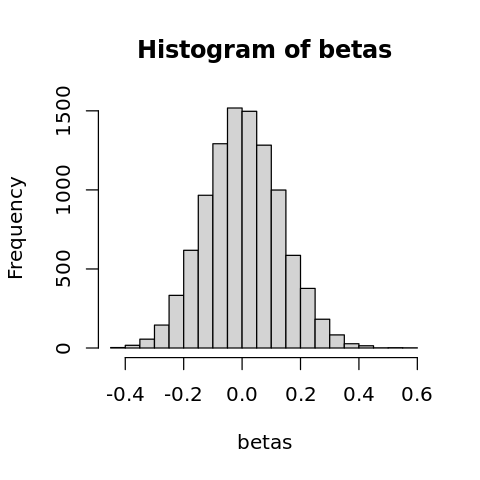

In [7]:
## Performing regression generating a null distribution

fm = as.formula(paste("muts ~ scale(avg_DP) + scale(PMI) + sex  +Dx+Sequencing + YoA + ageOfDeath + causeOfDeath+ Institution"))
m0 = MASS::glm.nb(fm, data=c4_data %>% filter(!is.na(c4_data$avg_DP)))

m1 = MASS::glm.nb(muts ~ Dx, data=c4_data %>% filter(!is.na(c4_data$avg_DP)))

forward = step(m1, direction='forward', scope=formula(m0), trace=0)

set.seed(1)
B = 10000
betas = rep(0, B)
pvals = rep(0, B)
for (i in 1:B){
    pdx = sample(c4_data$Dx)
    tmp = c4_data %>% mutate(Dx= pdx) %>% filter(!is.na(avg_DP)) %>%
         dplyr::select(c("avg_DP","PMI","sex",starts_with("PC"), "Dx","Sequencing",
                       "YoA","ageOfDeath","causeOfDeath","Institution", "muts")) %>% drop_na()
#     fm = as.formula(paste("muts ~ scale(avg_DP) + scale(PMI) + sex + PC1 + PC2 + PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10 +Dx+Sequencing + YoA + ageOfDeath + causeOfDeath+ Institution"))
    m0 = MASS::glm.nb(formula(forward), data=tmp)

#     m1 = MASS::glm.nb(muts ~ Dx, data=tmp)
#     tmp_forward = step(m1, direction='forward', scope=formula(m0), trace=0)
    betas[i] = as.numeric(m0$coefficients["DxSCZ"])
    pvals[i] = summary(m0)$coefficients["DxSCZ","Pr(>|z|)"]
    
}

## Calculate the p-value
2*sum(forward$coefficients["DxSCZ"] < betas)/B

## null distribution
options(repr.plot.width=4, repr.plot.height=4)
hist(betas)

In [8]:
summary(forward)


Call:
MASS::glm.nb(formula = muts ~ Dx + scale(avg_DP) + scale(PMI), 
    data = c4_data %>% filter(!is.na(c4_data$avg_DP)), init.theta = 7.702424916, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1427  -0.6770  -0.1366   0.7316   1.8869  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    3.22156    0.12239  26.322   <2e-16 ***
DxSCZ          0.26284    0.13843   1.899   0.0576 .  
scale(avg_DP)  0.64654    0.05905  10.950   <2e-16 ***
scale(PMI)    -0.14227    0.05778  -2.462   0.0138 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(7.7024) family taken to be 1)

    Null deviance: 161.147  on 53  degrees of freedom
Residual deviance:  54.872  on 50  degrees of freedom
AIC: 430.92

Number of Fisher Scoring iterations: 1


              Theta:  7.70 
          Std. Err.:  1.86 

 2 x log-likelihood:  -420.921 

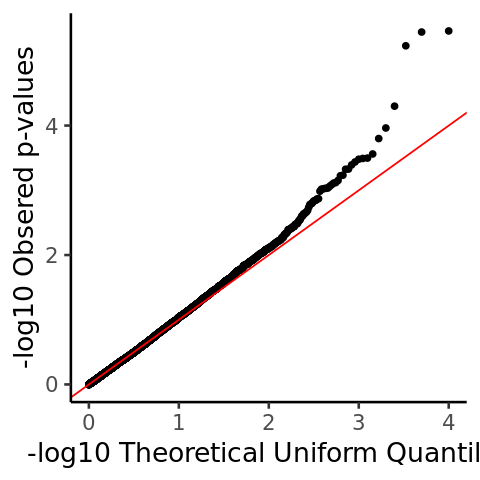

In [9]:
res = data.frame(betas=betas, p_val=pvals)

# pacman::p_load(utilities)

p1 = res %>% ggplot(aes(x= -log10(1:nrow(.)/(nrow(.)+1)), y=-log10(sort(pvals)))) +
    geom_point() +
    geom_abline(slope = 1,color="red") +
    theme_classic(16)+
    labs(x="-log10 Theoretical Uniform Quantiles",y="-log10 Obsered p-values") 

p1
ggsave(filename = "../../figures/qqplot_pvalue_genomewide_burden.pdf",device="pdf",width=4,height=4)